In [1]:
#Imports
#Imports
import numpy as np
import pandas as pd
import seaborn as sns
import ast, json
import math
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import ttest_1samp
from statsmodels.stats import weightstats as stests
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
#Useful methods
def get_elems_list(row, cols):
    elem_comb = {}
    elem_list = []
    i = 0
    for a in row:
        if not math.isnan(a):
            elem_list.append(cols[i])
        i+=1
    elem_comb['elements'] = elem_list
    return elem_comb

def get_data_rep(df):
    elements = get_elements(df)
    ecols = elements.columns
    data = df.drop(columns = ecols)
    e = pd.DataFrame()
    for i in range (0, len(elements)):
        e =e.append(get_elems_list(elements.loc[i], ecols), ignore_index=True)
    print(e)
    data['elements'] = e['elements']
    return data

def get_oth_props(df):
    elements = get_elements(df)
    ecols = elements.columns
    data = df.drop(columns = ecols)
    return data
def get_chi_corrs(df, func, ind):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            try:
                a  = []
                a.append(r)
                a.append(c)
                pvalues[r][c] = round(func(df[a])[ind], 4)
            except:
                print('err here')
    return pvalues

def run_on_df(df, f):
    a = pd.DataFrame()
    for c in df.columns:
        a[c] = f(df[c],0)
    return a

def get_heatmap(df):
    return df.style.background_gradient(cmap='magma') 

def get_corrs(df, func, ind):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(func(df[r], df[c])[ind], 4)

    return pvalues

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

def notnulls(data, col):
    return data[data[col].notnull()][col]

def get_counts_df(data):
    return pd.DataFrame(data.count()).transpose()

def numerify_df(data):
    for c in data.columns:
        try:
            data[c] = data[c].astype(float)
        except:
            print(c)
    return data

def drop_txt_rows(data):
    for col in data.columns:
        if data[col].dtype ==object:
            data = data.drop(col, axis=1)  
    data = data.fillna(0)
    return data

def get_elements(df):
    new_cols = []
    for c in df.columns:
        if len(c)<3:
            new_cols.append(c)
            
    return df[new_cols]

def get_pwr_corrs(df, func):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            if r==c:
                pvalues[r][c]=0
            else:
                pvalues[r][c] = round(np.mean(get_power(df, r, c, func)[0]), 4)

    return pvalues
            

In [3]:
df = pd.read_csv("final_numeric_data.csv").drop(columns = {'Unnamed: 0'})
columns = list(df.columns)
elems = get_elements(df)
elems = numerify_df(elems).astype(float).to_numpy()
elems[elems==0] = np.nan
df = numerify_df(df).astype(float).to_numpy()
df[df==0] = np.nan

/home/prasann/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
def get_model_err(df,prop, model):
    tmp = np.concatenate([elems, df[:,columns.index(prop)].reshape(3255,1)], axis=1)
    tmp = np.nan_to_num(tmp)
    #tmp[tmp==0] = np.nan
    #tmp = tmp[pd.notnull(tmp[:,-1])]
    y = tmp[:,-1]
    X = np.nan_to_num(tmp)
    X = X[:,:-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
    lin_reg = model
    lin_reg.fit(X_train, y_train)
    pred = lin_reg.predict(X_test)
    err = mean_squared_error(y_test, pred)
    return err

def get_model_residual(df,prop, model):
    tmp = np.concatenate([elems, df[:,columns.index(prop)].reshape(3255,1)], axis=1)
    tmp = np.nan_to_num(tmp)
    #tmp[tmp==0] = np.nan
    #tmp = tmp[pd.notnull(tmp[:,-1])]
    y = tmp[:,-1]
    X = np.nan_to_num(tmp)
    X = X[:,:-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)
    lin_reg = ResidualsPlot(model)
    lin_reg.fit(X_train, y_train)
    lin_reg.score(X_test, y_test)
    return lin_reg

In [27]:
get_model_err(df, "Category")

TypeError: get_model_err() missing 1 required positional argument: 'model'

In [28]:
print(df[:,columns.index(columns[2])].reshape(3255,1))

[[nan]
 [nan]
 [nan]
 ...
 [nan]
 [nan]
 [nan]]


In [13]:
def try_model(model):
    a = []
    for i in range (0,16):
        err = get_model_err(df, columns[i],model)
        a.append(err)
    i = 0
    for c in a:
        if c<1:
            print(columns[i] +" "+str(c))
        i+=1
        
def get_res_plots(model):
    a = []
    for i in range (0,16):
        err = get_model_residual(df, columns[i],model)
        err.show()
        a.append(err)

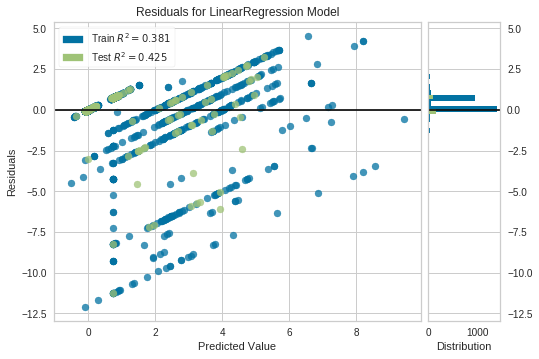

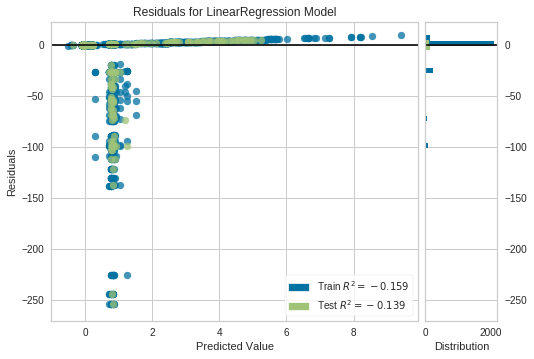

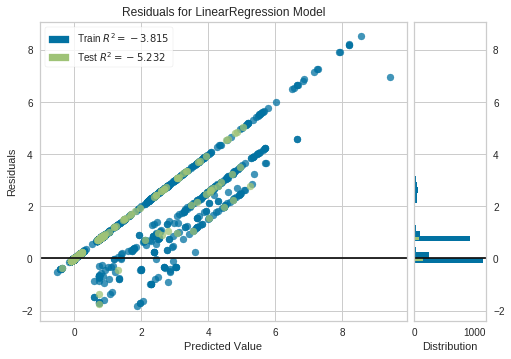

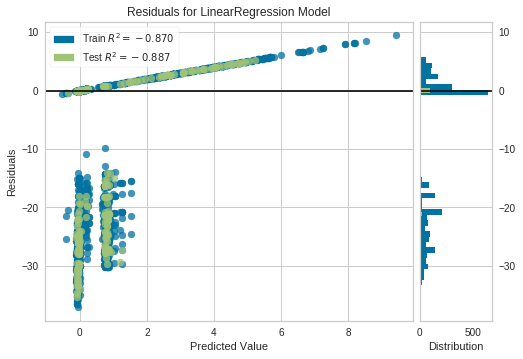

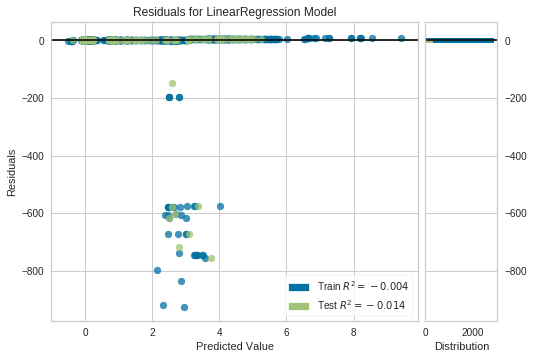

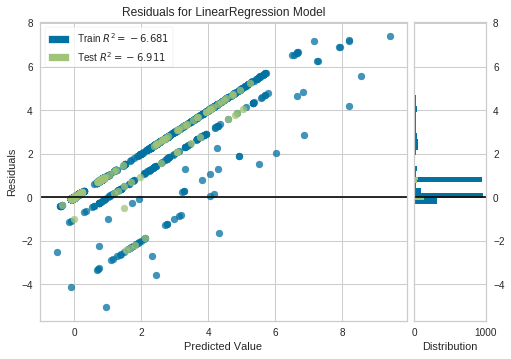

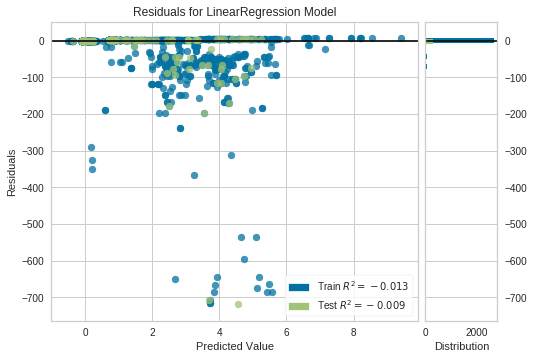

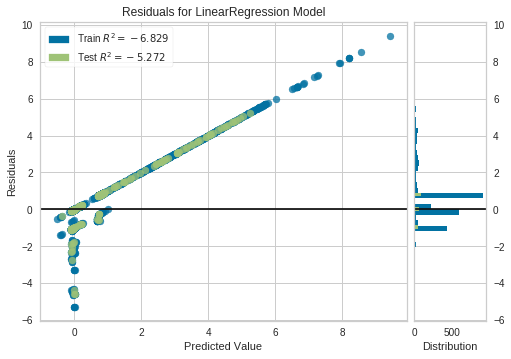

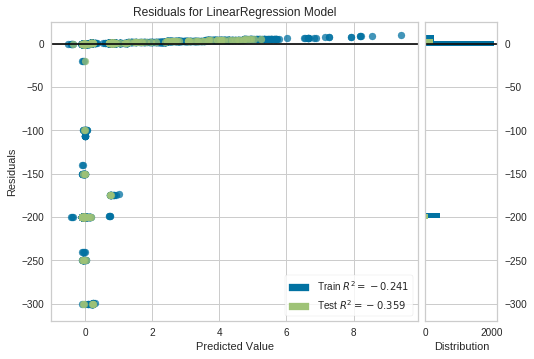

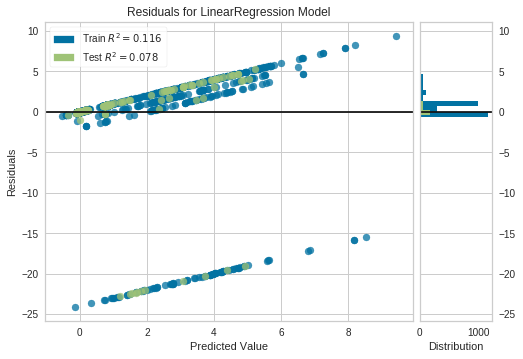

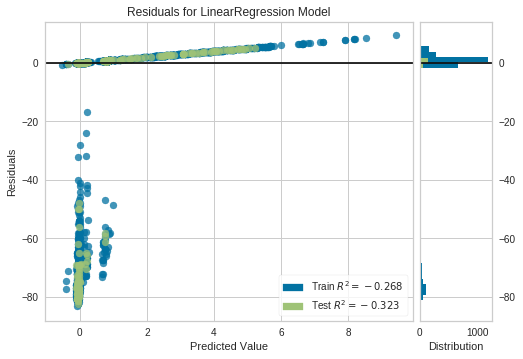

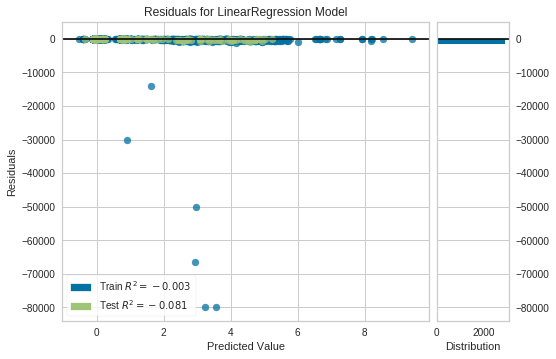

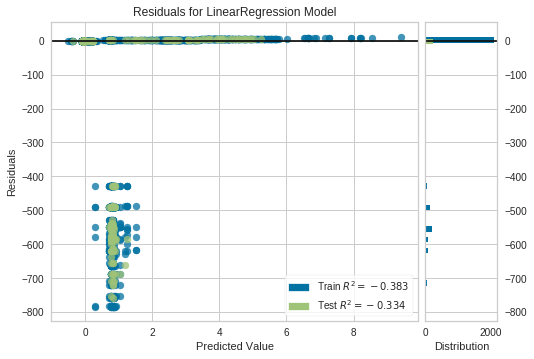

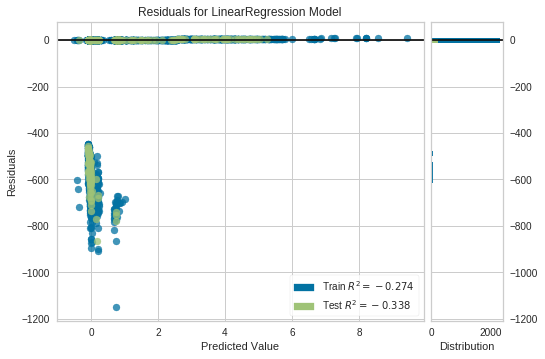

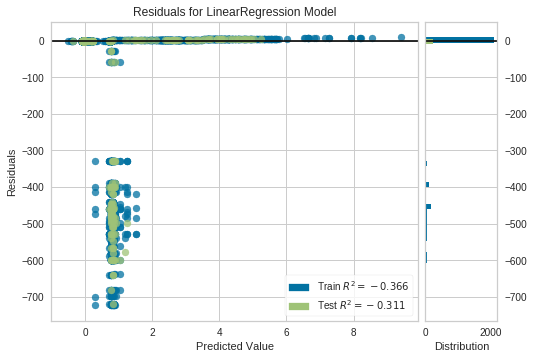

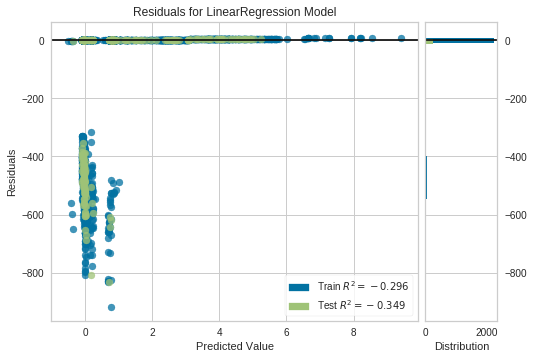

In [16]:
get_res_plots(linear_model.LinearRegression())


In [8]:
from sklearn import tree
from yellowbrick.regressor import ResidualsPlot

In [47]:
try_model(ensemble.RandomForestRegressor())

/home/prasann/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


DIN_W 0.08260916138087539
Hardness_Scale 0.0955613745053307
Manual metal arc_Heat input 0.36290975718996726


In [60]:
try_model(linear_model.PassiveAggressiveRegressor())

Manual metal arc_Heat input 0.3882254401733745
